In [41]:
import os
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import vit_b_16
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from torchvision import datasets
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vit_b_16(weights="IMAGENET1K_V1")

weight_path = r"/kaggle/input/celeb-face-regconization-vit/best_vit_face.pth"
num_classes = 17  # 👈 change this to your number of celebrity classes
model.heads.head = torch.nn.Linear(model.heads.head.in_features, num_classes)
state_dict = torch.load(weight_path, map_location="cpu")
model.load_state_dict(state_dict)
model.to(device)
print(" Weights loaded successfully!")

model.eval()

 Weights loaded successfully!


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [42]:
DATASET_DIR = "/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset"   # path to your dataset
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4
SEED = 42
IMG_SIZE = 224

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [43]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [44]:
# Load dataset
full_dataset = datasets.ImageFolder(DATASET_DIR, transform=train_transforms)

# Calculate sizes
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [45]:
# Load dataset
full_dataset = datasets.ImageFolder(DATASET_DIR, transform=train_transforms)

# Calculate sizes
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Important: set transform for val/test
val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [48]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average=None)   # per class
recall = recall_score(all_labels, all_preds, average=None)         # per class
f1 = f1_score(all_labels, all_preds, average=None)                 # per class

conf_mat = confusion_matrix(all_labels, all_preds)

print("\n" + "="*60)
print("📊 KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH".center(60))
print("="*60)

print(f"✅ Accuracy (Độ chính xác tổng thể): {accuracy:.4f}")
print("-"*60)

# Convert precision, recall, F1 to table
metrics_df = pd.DataFrame({
    "Precision (Độ chính xác)": precision,
    "Recall (Độ bao phủ)": recall,
    "F1-score": f1
}, index=class_names)  # ✅ dùng class_names làm index

print("\n📍 Chỉ số theo từng lớp:\n")
print(metrics_df.round(4))

print("\n" + "-"*60)
print("📋 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))  # ✅ thêm target_names

print("="*60)
print("✅ Đánh giá hoàn tất")
print("="*60)

print("\n📌 Confusion Matrix (Ma trận nhầm lẫn):")
print(conf_mat)



                 📊 KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH                 
✅ Accuracy (Độ chính xác tổng thể): 0.8500
------------------------------------------------------------

📍 Chỉ số theo từng lớp:

                    Precision (Độ chính xác)  Recall (Độ bao phủ)  F1-score
Angelina Jolie                        0.6667               0.5714    0.6154
Brad Pitt                             0.8000               0.7273    0.7619
Denzel Washington                     0.8571               0.7500    0.8000
Hugh Jackman                          0.7692               1.0000    0.8696
Jennifer Lawrence                     0.7500               0.8571    0.8000
Johnny Depp                           1.0000               1.0000    1.0000
Kate Winslet                          1.0000               0.9091    0.9524
Leonardo DiCaprio                     0.9091               0.8333    0.8696
Megan Fox                             0.8750               0.8235    0.8485
Natalie Portman                       0.5714    

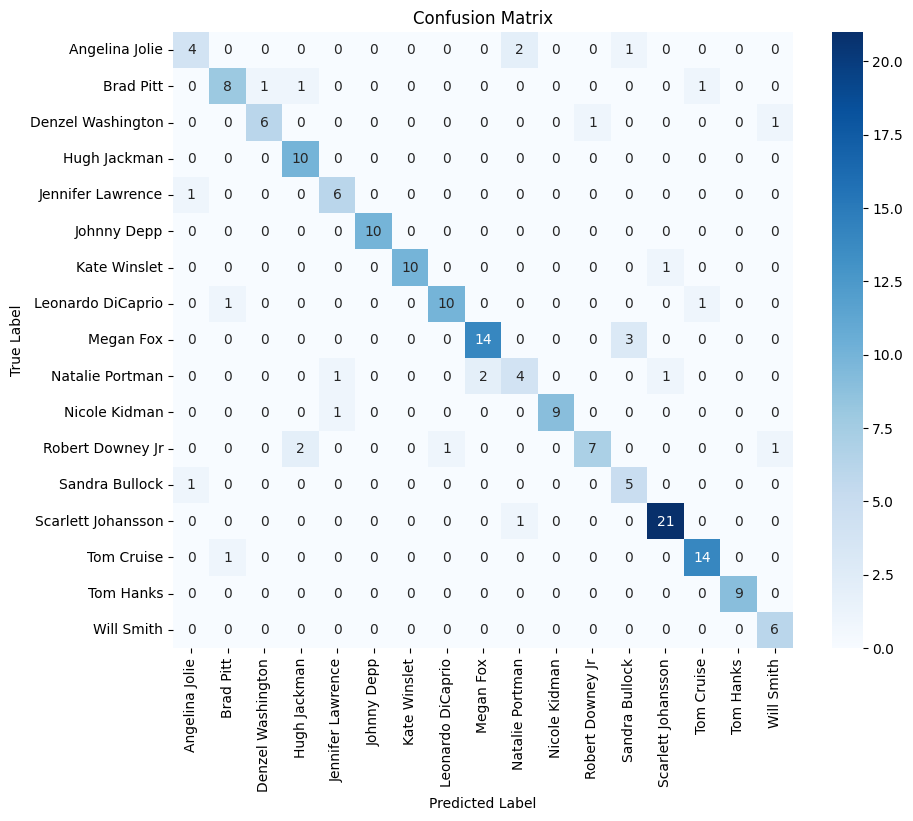

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()